https://stackoverflow.com/questions/34975972/how-can-i-make-a-video-from-array-of-images-in-matplotlib

In [1]:
# Complicated way to import finis if not installed

import os
import sys
finis_path = "../tp" #Folder containing finis folder
finis_abs_path = os.path.abspath(finis_path)
sys.path.append(finis_abs_path)

import finis
import numpy as np
import scipy.sparse as sp
import scipy
import pyamg
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import ode, solve_ivp
from scipy.optimize import approx_fprime
from utils import update_progress
import time

%matplotlib inline

In [10]:
def f_helper(x, y, y_balls):
    nballs = int(y_balls.size) // 2
    res = -9.81*np.ones_like(x)
    rho = 16.0 / np.pi
    
    #inside = np.zeros((x.size, ), dtype=np.bool)
    for i in range(nballs):
        #inside = np.logical_or(inside, (x-y_balls[2*i])**2 + (y-y_balls[2*i+1])**2 <= 0.25**2)
        inside = (x-y_balls[2*i])**2 + (y-y_balls[2*i+1])**2 <= 0.25**2
        res[inside] = -9.81*(1 + 0.25*i)*rho
        
    return res
    

def fem_rhs(t, y, eps=1e-4, debug=False):
    if debug:
        print("fem rhs: t = {}. y = {}".format(t, y))
    vertices = np.array([[0., 0], [2, 0], [2, 10], [0, 10]])
    mesh = finis.triangulate(vertices=vertices, max_area=0.05)
    fe_u = finis.fe_space(mesh, order=2, order_int=2)
    fe_p = finis.fe_space(mesh, order=1, order_int=2)
    
    dim_u = fe_u['dof'].shape[0]
    dim_p = fe_p['dof'].shape[0]
    
    assert np.array_equal(fe_u['integ'], fe_p['integ']), "FE Spaces not compatible"
    assert np.array_equal(fe_u['w'], fe_p['w']), "FE integration weights not compatible"
    
    # Free upper boundary
    markers = fe_u['markers']
    h_bnd = np.logical_or(fe_u['dof'][:,0] == 0, fe_u['dof'][:,0] == 2)
    not_top_bnd = fe_u['dof'][:,1] < 10.0
    markers = np.logical_and(markers, np.logical_or(h_bnd, not_top_bnd))
    
    nballs = int(y.size) // 2
    inside_integ = np.zeros((fe_u['integ'].shape[0], ), dtype=np.bool)
    for i in range(nballs):
        inside_integ = np.logical_or(inside_integ, (fe_u['integ'][:,0]-y[2*i])**2 + (fe_u['integ'][:,1]-y[2*i+1])**2 <= 0.25**2)
    

    # Setting up system
    f1 = lambda x,y: np.zeros_like(x)
    f2 = lambda x_in, y_in: f_helper(x_in, y_in, y_balls=y)
      

    # Construct non-dirichlet RHS
    W = sp.spdiags([fe_u['w']], [0], m=fe_u['w'].size, n=fe_u['w'].size)
    A11 = fe_u['DUX'].transpose().dot(W).dot(fe_u['DUX']) + fe_u['DUY'].transpose().dot(W).dot(fe_u['DUY'])
    A22 = A11
    A12 = fe_u['DUY'].transpose().dot(W).dot(fe_u['DUX'])
    A21 = A12.transpose()
    A13 = -fe_u['DUX'].transpose().dot(W).dot(fe_p['U'])
    A23 = -fe_u['DUY'].transpose().dot(W).dot(fe_p['U'])
    

    # Question 14 Regularizer
    w_inside = np.copy(fe_u['w'])
    w_inside[np.logical_not(inside_integ)] = 0.0
    
    assert fe_u['w'].shape == w_inside.shape
    assert np.allclose(np.sum(fe_u['w'][inside_integ]), np.sum(w_inside)), "Must have same sum"
    
    W_inside = sp.spdiags([w_inside], [0], m=w_inside.size, n=w_inside.size)
    A_inside = (1./eps)*(fe_u['DUX'].transpose().dot(W_inside).dot(fe_u['DUX']) + fe_u['DUY'].transpose().dot(W_inside).dot(fe_u['DUY']))
    A12i = (1./eps)*(fe_u['DUY'].transpose().dot(W_inside).dot(fe_u['DUX']))
    A21i = (1./eps)*(fe_u['DUX'].transpose().dot(W_inside).dot(fe_u['DUY']))
    A_test  = sp.bmat([[A_inside, A12i, None], [A21i, A_inside, None], [None, None, sp.coo_matrix((dim_p, dim_p))]], format='csr')
    assert np.allclose((A_test - A_test.transpose()).data / np.amax(np.abs(A_test.data)), 0), "A_test is not numerically symmetric!"
    A = sp.bmat([[A11, A12, A13], [A21, A22, A23], [A13.transpose(), A23.transpose(), None]], format='csr')
    assert np.allclose((A - A.transpose()).data / np.amax(np.abs(A.data)), 0), "A is not numerically symmetric!"

    # Construct non-dirichlet LHS
    F1int = f1(fe_u['integ'][:,0], fe_u['integ'][:,1])
    F2int = f2(fe_u['integ'][:,0], fe_u['integ'][:,1])

    _F1 = np.concatenate((
        fe_u['U'].transpose().dot(W).dot(F1int),
        fe_u['U'].transpose().dot(W).dot(F2int),
        np.zeros(dim_p, )
    ))
    F = _F1

    # Apply dirichlet boundary
    row = np.where(markers==0)[0]
    col = np.arange(row.size)
    data = np.ones((row.size, ), dtype=np.float)
    P_u = sp.csr_matrix((data, (row, col)), shape=(markers.size, row.size))
    dim_ud = P_u.shape[1]
    P = sp.bmat([[P_u, None, None], [None, P_u, None], [None, None, sp.eye(dim_p)]], format='csr')
    Ad = P.transpose().dot(A).dot(P)
    assert np.allclose((Ad - Ad.transpose()).data / np.amax(np.abs(Ad.data)), 0), "Ad is not numerically symmetric!"
    Fd = P.transpose().dot(F)

    A_test_d = P.transpose().dot(A_test).dot(P)

    # Solve
    x = sp.linalg.spsolve(Ad + A_test_d, Fd)

    # Transform back (Dirichlet)
    u_h = P.dot(x)
    u1_h = u_h[0:dim_u]
    u2_h = u_h[dim_u:2*dim_u]
    p_h = u_h[2*dim_u:]
    assert p_h.size == dim_p
    
    dy = np.zeros_like(y)
    for i in range(nballs):
        inside_integ_local = (fe_u['integ'][:,0]-y[2*i])**2 + (fe_u['integ'][:,1]-y[2*i+1])**2 <= 0.25**2
        w_inside_local = np.copy(fe_u['w'])
        w_inside_local[np.logical_not(inside_integ_local)] = 0.0
        
        A_v = ((1./np.sum(w_inside_local))*fe_u['U'])
        dy[2*i] = np.sum(A_v.dot(u1_h) * w_inside_local)
        dy[2*i+1] = np.sum(A_v.dot(u2_h) * w_inside_local)
    
    return dy

def fem_solve(fe_u, fe_p, y, eps=1e-4):
    dim_u = fe_u['dof'].shape[0]
    dim_p = fe_p['dof'].shape[0]
    
    assert np.array_equal(fe_u['integ'], fe_p['integ']), "FE Spaces not compatible"
    assert np.array_equal(fe_u['w'], fe_p['w']), "FE integration weights not compatible"
    
    # Free upper boundary
    markers = fe_u['markers']
    h_bnd = np.logical_or(fe_u['dof'][:,0] == 0, fe_u['dof'][:,0] == 2)
    not_top_bnd = fe_u['dof'][:,1] < 10.0
    markers = np.logical_and(markers, np.logical_or(h_bnd, not_top_bnd))
    
    nballs = int(y.size) // 2
    inside_integ = np.zeros((fe_u['integ'].shape[0], ), dtype=np.bool)
    for i in range(nballs):
        inside_integ = np.logical_or(inside_integ, (fe_u['integ'][:,0]-y[2*i])**2 + (fe_u['integ'][:,1]-y[2*i+1])**2 <= 0.25**2)
    

    # Setting up system
    f1 = lambda x,y: np.zeros_like(x)
    f2 = lambda x_in, y_in: f_helper(x_in, y_in, y_balls=y)
      

    # Construct non-dirichlet RHS
    W = sp.spdiags([fe_u['w']], [0], m=fe_u['w'].size, n=fe_u['w'].size)
    A11 = fe_u['DUX'].transpose().dot(W).dot(fe_u['DUX']) + fe_u['DUY'].transpose().dot(W).dot(fe_u['DUY'])
    A22 = A11
    A12 = fe_u['DUY'].transpose().dot(W).dot(fe_u['DUX'])
    A21 = A12.transpose()
    A13 = -fe_u['DUX'].transpose().dot(W).dot(fe_p['U'])
    A23 = -fe_u['DUY'].transpose().dot(W).dot(fe_p['U'])
    

    # Question 14 Regularizer
    w_inside = np.copy(fe_u['w'])
    w_inside[np.logical_not(inside_integ)] = 0.0
    
    assert fe_u['w'].shape == w_inside.shape
    assert np.allclose(np.sum(fe_u['w'][inside_integ]), np.sum(w_inside)), "Must have same sum"
    
    W_inside = sp.spdiags([w_inside], [0], m=w_inside.size, n=w_inside.size)
    A_inside = (1./eps)*(fe_u['DUX'].transpose().dot(W_inside).dot(fe_u['DUX']) + fe_u['DUY'].transpose().dot(W_inside).dot(fe_u['DUY']))
    A12i = (1./eps)*(fe_u['DUY'].transpose().dot(W_inside).dot(fe_u['DUX']))
    A21i = (1./eps)*(fe_u['DUX'].transpose().dot(W_inside).dot(fe_u['DUY']))
    A_test  = sp.bmat([[A_inside, A12i, None], [A21i, A_inside, None], [None, None, sp.coo_matrix((dim_p, dim_p))]], format='csr')
    assert np.allclose((A_test - A_test.transpose()).data / np.amax(np.abs(A_test.data)), 0), "A_test is not numerically symmetric!"
    A = sp.bmat([[A11, A12, A13], [A21, A22, A23], [A13.transpose(), A23.transpose(), None]], format='csr')
    assert np.allclose((A - A.transpose()).data / np.amax(np.abs(A.data)), 0), "A is not numerically symmetric!"

    # Construct non-dirichlet LHS
    F1int = f1(fe_u['integ'][:,0], fe_u['integ'][:,1])
    F2int = f2(fe_u['integ'][:,0], fe_u['integ'][:,1])

    _F1 = np.concatenate((
        fe_u['U'].transpose().dot(W).dot(F1int),
        fe_u['U'].transpose().dot(W).dot(F2int),
        np.zeros(dim_p, )
    ))
    F = _F1

    # Apply dirichlet boundary
    row = np.where(markers==0)[0]
    col = np.arange(row.size)
    data = np.ones((row.size, ), dtype=np.float)
    P_u = sp.csr_matrix((data, (row, col)), shape=(markers.size, row.size))
    dim_ud = P_u.shape[1]
    P = sp.bmat([[P_u, None, None], [None, P_u, None], [None, None, sp.eye(dim_p)]], format='csr')
    Ad = P.transpose().dot(A).dot(P)
    assert np.allclose((Ad - Ad.transpose()).data / np.amax(np.abs(Ad.data)), 0), "Ad is not numerically symmetric!"
    Fd = P.transpose().dot(F)

    A_test_d = P.transpose().dot(A_test).dot(P)

    # Solve
    x = sp.linalg.spsolve(Ad + A_test_d, Fd)

    # Transform back (Dirichlet)
    u_h = P.dot(x)
    u1_h = u_h[0:dim_u]
    u2_h = u_h[dim_u:2*dim_u]
    p_h = u_h[2*dim_u:]
    assert p_h.size == dim_p
    
    dy = np.zeros_like(y)
    for i in range(nballs):
        inside_integ_local = (fe_u['integ'][:,0]-y[2*i])**2 + (fe_u['integ'][:,1]-y[2*i+1])**2 <= 0.25**2
        w_inside_local = np.copy(fe_u['w'])
        w_inside_local[np.logical_not(inside_integ_local)] = 0.0
        
        A_v = ((1./np.sum(w_inside_local))*fe_u['U'])
        dy[2*i] = np.sum(A_v.dot(u1_h) * w_inside_local)
        dy[2*i+1] = np.sum(A_v.dot(u2_h) * w_inside_local)
    
    return u1_h, u2_h, p_h, dy


def fem_movie(foldername='images/', T=20.0):
    y = np.array([2., 8.1, 2.45, 9])
    dt = 1.0/30
    vertices = np.array([[0., 0], [4, 0], [4, 10], [0, 10]])
    mesh = finis.triangulate(vertices=vertices, max_area=0.01)
    fe_u = finis.fe_space(mesh, order=2, order_int=2)
    fe_p = finis.fe_space(mesh, order=1, order_int=2)
    
    u1_h, u2_h, p_h, dy = fem_solve(fe_u, fe_p, y, eps=1e-6)
    fig = plt.figure(figsize=(9,5))
    ax = fig.add_subplot(1, 1, 1)
    tricol = plt.tripcolor(fe_u['dof'][:,0], fe_u['dof'][:,1], u2_h, shading='flat', vmin=-2, vmax=2)
    c1=plt.Circle((y[0],y[1]),.25,color='w')
    ax.add_artist(c1)
    c2=plt.Circle((y[2],y[3]),.25,color='w')
    ax.add_artist(c2)

    ax.set_title("$u_y$")
    ax.set_xlabel("$x$")
    plt.colorbar()
    ax.set_aspect('equal')
    
    _i_max = int(T/dt)+2
    starttime=time.time()
    for _i in range(_i_max):
        if _i > 0: 
            u1_h, u2_h, p_h, dy = fem_solve(fe_u, fe_p, y, eps=1e-6)
        ax.clear()
        c1=plt.Circle((y[0],y[1]),.25,color='w')
        ax.add_artist(c1)
        c2=plt.Circle((y[2],y[3]),.25,color='w')
        ax.add_artist(c2)
        tricol = plt.tripcolor(fe_u['dof'][:,0], fe_u['dof'][:,1], u2_h, shading='flat', vmin=-2, vmax=2)
        plt.savefig(foldername+'movie{}.png'.format(_i))
        np.save(foldername+'y{}.npy'.format(_i), y)

        update_progress(_i / _i_max, starttime=starttime)
        y = y + dt*dy
    
    

def fem_plot(fe_u, fe_p, u1_h, u2_h, p_h):
    shading= 'flat' # flat or gouraud
    max_u = max([
        np.amax(u1_h),
        np.amax(u2_h),
    ])
    min_u = min([
        np.amin(u1_h),
        np.amin(u2_h),
    ])

    fig = plt.figure(figsize=(9,5))
    ax = fig.add_subplot(1, 3, 1)
    plt.tripcolor(fe_u['dof'][:,0], fe_u['dof'][:,1], u1_h, shading=shading, vmin=min_u, vmax=max_u)
    ax.set_title("U_x")
    ax.set_xlabel("x")
    plt.colorbar()

    fig.add_subplot(1, 3, 2, sharex=ax, sharey=ax)
    plt.tripcolor(fe_u['dof'][:,0], fe_u['dof'][:,1], u2_h, shading=shading, vmin=min_u, vmax=max_u)
    plt.title("U_y")
    plt.xlabel("x")
    plt.colorbar()

    ax = fig.add_subplot(1, 3, 3, sharex=ax, sharey=ax)
    plt.tripcolor(fe_p['dof'][:,0], fe_p['dof'][:,1], p_h,  shading=shading)
    plt.title("P")
    plt.xlabel("x")
    plt.colorbar()

    plt.tight_layout()
    plt.show()
    
def fem_plot2(fe_u, fe_p, u1_h, u2_h, p_h, y):
    shading= 'flat' # flat or gouraud
    max_u = max([
        np.amax(u1_h),
        np.amax(u2_h),
    ])
    min_u = min([
        np.amin(u1_h),
        np.amin(u2_h),
    ])

    fig = plt.figure(figsize=(9,5))
    ax = fig.add_subplot(1, 3, 1)
    plt.tripcolor(fe_u['dof'][:,0], fe_u['dof'][:,1], u1_h, shading=shading, vmin=min_u, vmax=max_u)
    nballs = int(y.size) // 2
    for i in range(nballs):
        _tt = np.linspace(0, 2*np.pi, 250, endpoint=False)
        plt.plot(0.25*np.cos(_tt)+y[2*i], 0.25*np.sin(_tt)+y[2*i+1], "w")
    ax.set_title("U_x")
    ax.set_xlabel("x")
    plt.colorbar()

    fig.add_subplot(1, 3, 2, sharex=ax, sharey=ax)
    plt.tripcolor(fe_u['dof'][:,0], fe_u['dof'][:,1], u2_h, shading=shading, vmin=min_u, vmax=max_u)
    nballs = int(y.size) // 2
    for i in range(nballs):
        _tt = np.linspace(0, 2*np.pi, 250, endpoint=False)
        plt.plot(0.25*np.cos(_tt)+y[2*i], 0.25*np.sin(_tt)+y[2*i+1], "w")
    plt.title("U_y")
    plt.xlabel("x")
    plt.colorbar()

    ax = fig.add_subplot(1, 3, 3, sharex=ax, sharey=ax)
    plt.tripcolor(fe_p['dof'][:,0], fe_p['dof'][:,1], p_h,  shading=shading)
    plt.title("P")
    plt.xlabel("x")
    plt.colorbar()

    plt.tight_layout()
    plt.show()

Percent: [#-------------------------------------------------]  1.16% 

KeyboardInterrupt: 

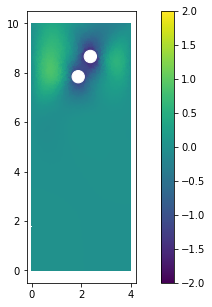

In [11]:
fem_movie()

In [ ]:
y = np.array([2., 8.1, 2.45, 9])
dt = 0.5
vertices = np.array([[0., 0], [4, 0], [4, 10], [0, 10]])
mesh = finis.triangulate(vertices=vertices, max_area=0.005)
fe_u = finis.fe_space(mesh, order=2, order_int=2)
fe_p = finis.fe_space(mesh, order=1, order_int=2)

In [ ]:
fig = plt.figure(figsize=(9,5))
ax = fig.add_subplot(1, 1, 1)
tricol = plt.tripcolor(fe_u['dof'][:,0], fe_u['dof'][:,1], u2_h, shading='flat', vmin=-2, vmax=2)
nballs = int(y.size) // 2
for i in range(nballs):
    _tt = np.linspace(0, 2*np.pi, 250, endpoint=False)
    plt.plot(0.25*np.cos(_tt)+y[2*i], 0.25*np.sin(_tt)+y[2*i+1], "w")
ax.set_title("U_x")
ax.set_xlabel("x")
plt.colorbar()
plt.show()

In [ ]:
tricol.set_array(u1_h)
plt.show()

In [ ]:
u1_h, u2_h, p_h, dy = fem_solve(fe_u, fe_p, y, eps=1e-6)
dt = 0.2
fig = plt.figure(figsize=(9,5))
ax = fig.add_subplot(1, 1, 1)
tricol = plt.tripcolor(fe_u['dof'][:,0], fe_u['dof'][:,1], u2_h, shading='flat', vmin=-2, vmax=2)
c1, = plt.plot(0.25*np.cos(_tt)+y[0], 0.25*np.sin(_tt)+y[1], "w")
c2, = plt.plot(0.25*np.cos(_tt)+y[2], 0.25*np.sin(_tt)+y[3], "w")
ax.set_title("U_x")
ax.set_xlabel("x")
plt.axis("equal")
plt.colorbar()

for _i in range(100):
    if _i > 0: 
        u1_h, u2_h, p_h, dy = fem_solve(fe_u, fe_p, y, eps=1e-6)
    ax.clear()
    #tricol.set_array(u2_h)
    #c1.set_xdata(0.25*np.cos(_tt)+y[0])
    #c1.set_ydata(0.25*np.sin(_tt)+y[1])
    #c2.set_xdata(0.25*np.cos(_tt)+y[2])
    #c2.set_ydata(0.25*np.sin(_tt)+y[3])
    tricol = plt.tripcolor(fe_u['dof'][:,0], fe_u['dof'][:,1], u2_h, shading='flat', vmin=-2, vmax=2)
    c1, = plt.plot(0.25*np.cos(_tt)+y[0], 0.25*np.sin(_tt)+y[1], "w")
    c2, = plt.plot(0.25*np.cos(_tt)+y[2], 0.25*np.sin(_tt)+y[3], "w")
    plt.savefig('movie{}.png'.format(_i))
    
    print(dy)
    y = y + dt*dy
    print(y)
    print("dist_y = {}".format(y[1]-y[3]))
    print("dist_x = {}".format(y[0]-y[2]))
    print("dist = {}".format(np.sqrt((y[0]-y[2])**2 + (y[1]-y[3])**2)-0.5))    

In [ ]:
%%time
f = lambda t, y: fem_rhs(t, y, eps=1e-5, debug=True)

tspan = np.array([0., 15])
y0 = np.array([1., 8, 1, 9])

sol = solve_ivp(f, tspan, y0, method='RK45', dense_output=True)
if sol.status < 0:
    print("Failed")
    print(sol.message)
else:
    print("Succeeded in {} steps with {} rhs calls".format(sol.t.size, sol.nfev))

In [ ]:
plt.figure(figsize=(7,7))
tt = np.linspace(sol.t[0], sol.t[-1], 10000)
Y = sol.sol(tt)
nballs = Y.shape[0] // 2
for i in range(nballs):
    plt.plot(Y[2*i,:], Y[2*i+1,:], '-', label='ball {}'.format(i))
plt.legend()
plt.axis([0, 2, 0, 10])
plt.axis("equal")
plt.show()

In [ ]:
sol.y[:,-1]

In [ ]:
%matplotlib inline

In [ ]:
tt = np.arange(sol.t[0], sol.t[-1], 1.0/30)

fig = plt.figure(figsize=(7,7))
t = sol.t[0]
y = sol.sol(t)
c1 = plt.Circle((y[0], y[1]), 0.25, color='b')
c2 = plt.Circle((y[2], y[3]), 0.25, color='g')
ax = fig.gca()

ax.add_artist(c1)
ax.add_artist(c2)
plt.plot([0, 2, 2, 0, 0], [0, 0, 10, 10, 0], 'k')
plt.axis([0, 2, 0, 10])
plt.axis("equal")

for i, t in enumerate(tt):
    y = sol.sol(t)
    c1.center = (y[0], y[1])
    c2.center = (y[2], y[3])
    plt.savefig('movie{}.png'.format(i))
print(y)

In [ ]:
plt.figure()
tt = np.linspace(sol.t[0], sol.t[-1], 10000)
Y = sol.sol(tt)
plt.plot(tt, np.sqrt((Y[0,:]-Y[2,:])**2 + (Y[1,:]-Y[3,:])**2)-0.5, '-', label='distance')
plt.legend()
plt.show()